
# RN–JD Prediction Market Prototype (Synthetic Demo)

This notebook implements a **Logit Jump–Diffusion** (Risk-Neutral Jump-Diffusion, RN–JD) model for **prediction-market probabilities** \(p_t\).
It contains:
- Simulation of logit-space jump–diffusion paths
- Microstructure noise filtering (median + EWMA)
- EM-style calibration to separate diffusion and jumps
- Numerical enforcement of risk-neutral (martingale) drift for \(p_t\)
- A simple belief-volatility surface estimator
- Example derivative-like instruments: variance-swap strike, corridor, first-passage (Monte Carlo)


> **This notebook uses only synthetic data** and is self-contained. Run the cells in order.


In [1]:

# Imports (standard scientific stack)
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import bisect
from scipy.signal import medfilt
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


C:\Users\mhbvp41\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED



## Background (short)

Prediction markets trade probabilities as prices. To build a standard, tradable risk language (like implied volatility in option markets),
we model the *logit* of the traded probability as a **jump–diffusion** under a **risk-neutral** measure (i.e., \(p_t\) is a martingale under \(Q\)).
This notebook implements a working prototype for simulation, calibration, and small derivative constructions.


In [13]:

# ------------------------ Utility transforms ------------------------
def logit(p):
    p = np.clip(p, 1e-12, 1 - 1e-12)
    return np.log(p / (1 - p))

def inv_logit(x):
    return 1 / (1 + np.exp(-x))


In [14]:

# ------------------------ Simulator: RN-Jump-Diffusion in logit space ------------------------
def simulate_rn_jd_logit(x0, mu, sigma, lam, jump_mu, jump_sigma, T, N, seed=None):
    """
    Simulate logit-space jump-diffusion:
      dx = mu dt + sigma dW + J dN
    where N is Poisson(lambda) with rate per unit time lam and J ~ Normal(jump_mu, jump_sigma).
    Returns times, x_t, p_t
    """
    rng = np.random.default_rng(seed)
    dt = T / N
    times = np.linspace(0, T, N+1)
    x = np.zeros(N+1)
    x[0] = x0
    for i in range(1, N+1):
        z = rng.standard_normal()
        dW = np.sqrt(dt) * z
        nj = rng.poisson(lam * dt)
        Jsum = 0.0
        if nj > 0:
            Jsum = rng.normal(loc=jump_mu * nj, scale=np.sqrt(nj) * jump_sigma)
        x[i] = x[i-1] + mu * dt + sigma * dW + Jsum
    p = inv_logit(x)
    return times, x, p


In [15]:

# ------------------------ Microstructure noise filter ------------------------
def filter_microstructure(p_series, window_med=5, ewma_alpha=0.15):
    """
    Remove discrete-tick noise and spikes using median filter + EWMA smoothing.
    p_series: pandas Series indexed by time
    """
    p = p_series.values
    k = window_med if window_med % 2 == 1 else window_med + 1
    p_med = medfilt(p, kernel_size=k)
    p_ewma = pd.Series(p_med).ewm(alpha=ewma_alpha).mean().values
    return pd.Series(p_ewma, index=p_series.index)


In [16]:

# ------------------------ EM-style calibration (mixture of two Gaussians on increments) ------------------------
def em_calibrate_jd(x, dt, max_iter=200, tol=1e-6, verbose=False):
    """
    Calibrate a two-component mixture model for increments dx:
       dx ~ (1 - w) * N(mu*dt, sigma^2*dt)  + w * N(mu*dt + jump_mean, sigma^2*dt + jump_var)
    Returns estimated params: mu, sigma, lam (per unit time), jump_mean, jump_sigma
    """
    dx = np.diff(x)
    n = dx.size
    # robust initial guesses
    mu = np.median(dx) / dt
    sigma = max(np.std(dx) / np.sqrt(dt), 1e-4)
    w = min(0.05, 0.2)
    jump_mean = np.mean(dx) - mu * dt if abs(np.mean(dx) - mu*dt) > 0 else 0.0
    jump_sigma = max(2.0 * sigma, 1e-4)

    prev_ll = -np.inf
    for it in range(max_iter):
        var0 = (sigma**2) * dt
        var1 = (sigma**2) * dt + (jump_sigma**2)
        mu0 = mu * dt
        mu1 = mu * dt + jump_mean
        var0 = max(var0, 1e-12)
        var1 = max(var1, 1e-12)
        p0 = (1 - w) * norm.pdf(dx, loc=mu0, scale=np.sqrt(var0))
        p1 = w * norm.pdf(dx, loc=mu1, scale=np.sqrt(var1))
        denom = p0 + p1 + 1e-300
        r = p1 / denom

        w_new = np.clip(np.mean(r), 1e-8, 0.999999)
        mean_dx = np.mean(dx)
        mu_new = (mean_dx - w_new * jump_mean) / dt
        res0 = (dx - mu_new * dt)**2
        res1 = (dx - (mu_new * dt + jump_mean))**2
        sigma2_new = (np.sum((1 - r) * res0) + np.sum(r * (res1 - jump_sigma**2))) / (n * dt)
        sigma_new = np.sqrt(max(sigma2_new, 1e-8))
        if np.sum(r) > 1e-6:
            jump_mean_new = np.sum(r * (dx - mu_new * dt)) / (np.sum(r))
            jump_var_new = max(np.sum(r * (dx - mu_new * dt - jump_mean_new)**2) / np.sum(r) - sigma_new**2 * dt, 1e-12)
            jump_sigma_new = np.sqrt(max(jump_var_new, 1e-8))
        else:
            jump_mean_new = jump_mean
            jump_sigma_new = jump_sigma

        p0 = (1 - w_new) * norm.pdf(dx, loc=mu_new * dt, scale=np.sqrt(max(sigma_new**2 * dt, 1e-12)))
        p1 = w_new * norm.pdf(dx, loc=mu_new * dt + jump_mean_new, scale=np.sqrt(max(sigma_new**2 * dt + jump_sigma_new**2, 1e-12)))
        ll = np.sum(np.log(p0 + p1 + 1e-300))

        if verbose and it % 20 == 0:
            print(f"Iter {it}: ll={ll:.3f}, mu={mu_new:.4f}, sigma={sigma_new:.4f}, w={w_new:.4f}, jump_mean={jump_mean_new:.4f}, jump_sigma={jump_sigma_new:.4f}")

        if abs(ll - prev_ll) < tol:
            mu, sigma, w, jump_mean, jump_sigma = mu_new, sigma_new, w_new, jump_mean_new, jump_sigma_new
            break
        mu, sigma, w, jump_mean, jump_sigma = mu_new, sigma_new, w_new, jump_mean_new, jump_sigma_new
        prev_ll = ll

    lam = w / dt
    return { "mu": mu, "sigma": sigma, "lam": lam, "jump_mean": jump_mean, "jump_sigma": jump_sigma, "mixture_w": w }


In [17]:

# ------------------------ Enforce RN drift numerically ------------------------
def enforce_rn_drift(x0, sigma, lam, jump_mean, jump_sigma, T, dt, mu_guess=0.0):
    """
    Numerically adjust mu so that E_Q[p_T] = p_0 (martingale condition under Q).
    """
    rng = np.random.default_rng(12345)
    npaths = 2000
    N = int(T / dt)
    def error_for_mu(mu_try):
        x = np.full(npaths, x0)
        for i in range(N):
            z = rng.standard_normal(npaths)
            dW = np.sqrt(dt) * z
            nj = rng.poisson(lam * dt, size=npaths)
            Jsum = np.where(nj > 0, rng.normal(loc=jump_mean * nj, scale=np.sqrt(nj) * jump_sigma), 0.0)
            x = x + mu_try * dt + sigma * dW + Jsum
        pT = 1 / (1 + np.exp(-x))
        return np.mean(pT) - (1 / (1 + np.exp(-x0)))

    left, right = -2.0, 2.0
    fl = error_for_mu(left)
    fr = error_for_mu(right)
    i = 0
    while fl * fr > 0 and i < 12:
        left *= 2
        right *= 2
        fl = error_for_mu(left)
        fr = error_for_mu(right)
        i += 1
    if fl * fr > 0:
        return mu_guess
    mu_star = bisect(error_for_mu, left, right, xtol=1e-3, maxiter=50)
    return mu_star


In [18]:

# ------------------------ Build belief-volatility surface ------------------------
def belief_vol_surface_from_series(p, times, maturities, quantiles=None):
    x = logit(np.asarray(p))
    dt = times[1] - times[0]
    results = {}
    if quantiles is None:
        quantiles = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    for T in maturities:
        nstep = max(1, int(round(T / dt)))
        if nstep >= len(x):
            results[T] = {"p_centers": [], "vol": []}
            continue
        x_start = x[:-nstep]
        x_end = x[nstep:]
        rv = (x_end - x_start)**2 / (T if T>0 else 1e-12)
        p_starts = inv_logit(x_start)
        bins = np.quantile(p_starts, quantiles)
        centers = []
        vols = []
        for i in range(len(bins)-1):
            mask = (p_starts >= bins[i]) & (p_starts < bins[i+1])
            vals = np.sqrt(rv[mask]) if np.any(mask) else np.array([])
            vols.append(np.nanmedian(vals) if vals.size>0 else np.nan)
            centers.append(0.5*(bins[i]+bins[i+1]))
        results[T] = {"p_centers": centers, "vol": vols}
    return results


In [19]:

# ------------------------ Pricing approximations using calibrated params ------------------------
def variance_swap_strike(sigma, lam, jump_mean, jump_sigma, T):
    jump_var = jump_sigma**2
    var = sigma**2 + lam * (jump_var + jump_mean**2)
    return np.sqrt(var)

def corridor_price_mc(x0, mu, sigma, lam, jump_mean, jump_sigma, T, Nstep, lower_p, upper_p, npaths=5000, seed=222):
    rng = np.random.default_rng(seed)
    dt = T / Nstep
    x = np.full(npaths, x0)
    in_corridor_counts = np.zeros(npaths)
    for i in range(Nstep):
        z = rng.standard_normal(npaths)
        dW = np.sqrt(dt) * z
        nj = rng.poisson(lam * dt, size=npaths)
        Jsum = np.where(nj > 0, rng.normal(loc=jump_mean * nj, scale=np.sqrt(nj) * jump_sigma), 0.0)
        x = x + mu * dt + sigma * dW + Jsum
        p = inv_logit(x)
        in_corridor_counts += ((p >= lower_p) & (p <= upper_p)).astype(float)
    prop = np.mean(in_corridor_counts / Nstep)
    return prop

def first_passage_prob_mc(x0, mu, sigma, lam, jump_mean, jump_sigma, T, Nstep, barrier_p, npaths=5000, seed=929):
    rng = np.random.default_rng(seed)
    dt = T / Nstep
    x = np.full(npaths, x0)
    crossed = np.zeros(npaths, dtype=bool)
    barrier_x = logit(barrier_p)
    for i in range(Nstep):
        z = rng.standard_normal(npaths)
        dW = np.sqrt(dt) * z
        nj = rng.poisson(lam * dt, size=npaths)
        Jsum = np.where(nj > 0, rng.normal(loc=jump_mean * nj, scale=np.sqrt(nj) * jump_sigma), 0.0)
        x = x + mu * dt + sigma * dW + Jsum
        newly = (x >= barrier_x) & (~crossed)
        crossed = crossed | newly
    return np.mean(crossed)


Calibrated (pre-RN adjust): {'mu': 5.342476275789297, 'sigma': 0.00010000177384454276, 'lam': 99.9999, 'jump_mean': -0.05956341848565985, 'jump_sigma': 0.016665650247166465, 'mixture_w': 0.999999}
Adjusted mu to enforce RN martingale (for horizon T=1.0): 6.0205
Maturity 0.02: centers [0.116 0.16  0.188 0.281 0.502] vols [0.029 0.085 0.124 0.101 0.096]
Maturity 0.05: centers [0.118 0.161 0.189 0.282 0.503] vols [0.043 0.113 0.2   0.179 0.138]
Maturity 0.1: centers [0.12  0.162 0.19  0.284 0.504] vols [0.055 0.121 0.272 0.236 0.199]
Maturity 0.2: centers [0.121 0.164 0.191 0.286 0.505] vols [0.09  0.14  0.387 0.281 0.303]
Maturity 1: centers [0.152 0.167 0.205 0.302 0.508] vols [0.318 0.194 0.217 0.657 1.119]
Maturity 2: centers [0.164 0.193 0.252 0.334 0.514] vols [0.452 0.167 0.374 0.721 1.478]
Maturity 3: centers [0.215 0.263 0.329 0.456 0.597] vols [0.595 0.639 0.533 0.648 1.343]
Variance-swap implied vol (logit-space, per-unit): 0.6185
Expected proportion of time in corridor [0.45,0

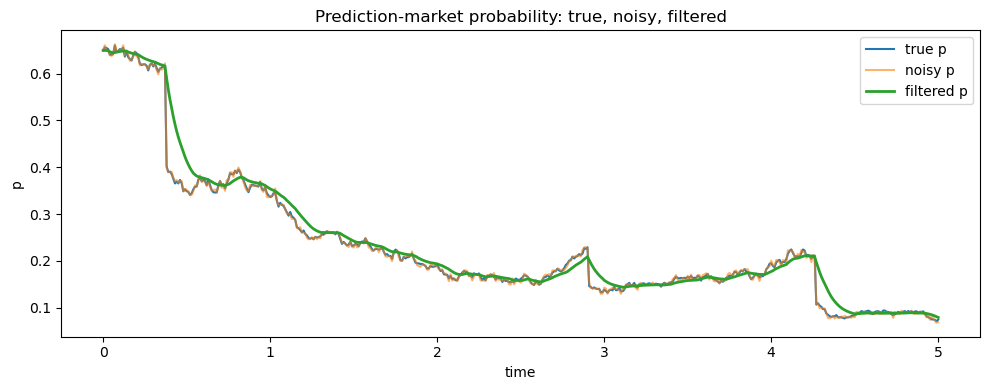

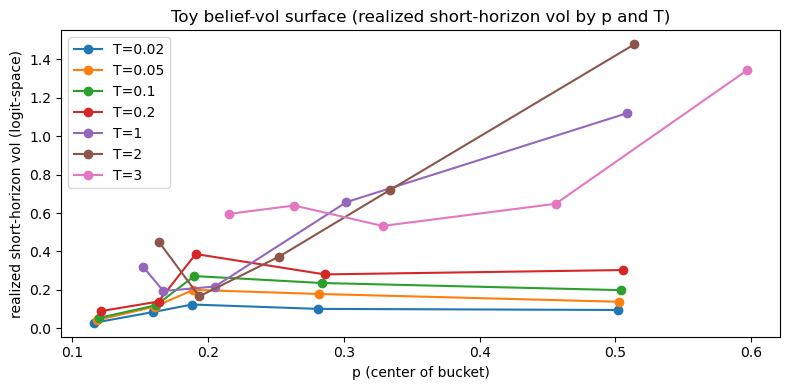

In [21]:

# ------------------------ Demo: simulate, add microstructure noise, calibrate, enforce RN drift, build surface ------------------------
def demo(show_plots=True):
    p0 = 0.65
    x0 = logit(p0)
    T = 5.0
    N = 500
    true_params = {"mu": -0.02, "sigma": 0.35, "lam": 0.8, "jump_mean": -0.8, "jump_sigma": 0.6}
    times, x_true, p_true = simulate_rn_jd_logit(x0, true_params["mu"], true_params["sigma"],
                                                true_params["lam"], true_params["jump_mean"],
                                                true_params["jump_sigma"], T, N, seed=1222)

    tick = 0.01
    rng = np.random.default_rng(7)
    p_noisy = np.round(p_true / tick) * tick + rng.normal(scale=0.002, size=len(p_true))

    t_index = pd.Index(times, name="t")
    p_series_noisy = pd.Series(p_noisy, index=t_index)
    p_filtered = filter_microstructure(p_series_noisy, window_med=5, ewma_alpha=0.12)
    x_filtered = logit(p_filtered.values)

    dt = T / N
    calib = em_calibrate_jd(x_filtered, dt, max_iter=400, tol=1e-6, verbose=False)
    print("Calibrated (pre-RN adjust):", calib)

    mu_star = enforce_rn_drift(x0, calib["sigma"], calib["lam"], calib["jump_mean"], calib["jump_sigma"], T=1.0, dt=dt, mu_guess=calib["mu"])
    print(f"Adjusted mu to enforce RN martingale (for horizon T=1.0): {mu_star:.4f}")
    calib["mu_rn"] = mu_star

    maturities = [0.02, 0.05, 0.1, 0.2, 1, 2, 3]
    surf = belief_vol_surface_from_series(p_filtered.values, times, maturities)
    for Tk, v in surf.items():
        print(f"Maturity {Tk}: centers {np.round(v['p_centers'],3)} vols {np.round(v['vol'],3)}")

    var_swap_vol = variance_swap_strike(calib["sigma"], calib["lam"], calib["jump_mean"], calib["jump_sigma"], T=1.0)
    corridor_prop = corridor_price_mc(x0, calib["mu_rn"], calib["sigma"], calib["lam"], calib["jump_mean"], calib["jump_sigma"], T=1.0, Nstep=200, lower_p=0.45, upper_p=0.75, npaths=3000)
    fp_prob = first_passage_prob_mc(x0, calib["mu_rn"], calib["sigma"], calib["lam"], calib["jump_mean"], calib["jump_sigma"], T=1.0, Nstep=200, barrier_p=0.8, npaths=3000)
    print(f"Variance-swap implied vol (logit-space, per-unit): {var_swap_vol:.4f}")
    print(f"Expected proportion of time in corridor [0.45,0.75]: {corridor_prop:.3f}")
    print(f"Probability of first passage above 0.8 by T=1: {fp_prob:.3f}")

    if show_plots:
        plt.figure(figsize=(10,4))
        plt.plot(times, p_true, label="true p")
        plt.plot(times, p_noisy, label="noisy p", alpha=0.6)
        plt.plot(times, p_filtered.values, label="filtered p", linewidth=2)
        plt.xlabel("time")
        plt.ylabel("p")
        plt.title("Prediction-market probability: true, noisy, filtered")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,4))
        for T_k, data in surf.items():
            centers = data["p_centers"]
            vols = data["vol"]
            if len(centers) > 0:
                plt.plot(centers, vols, marker='o', label=f"T={T_k}")
        plt.xlabel("p (center of bucket)")
        plt.ylabel("realized short-horizon vol (logit-space)")
        plt.title("Toy belief-vol surface (realized short-horizon vol by p and T)")
        plt.legend()
        plt.tight_layout()
        plt.show()

# run demo when executed
demo()


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

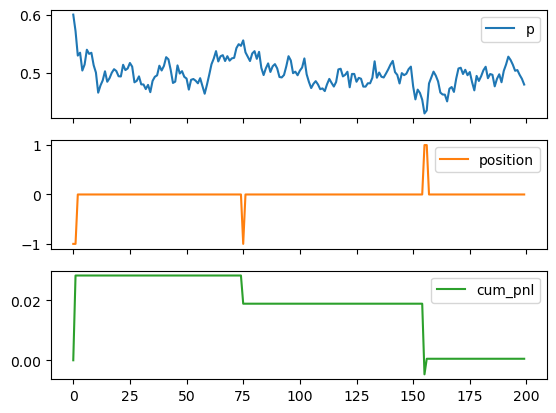

In [52]:
import numpy as np
import pandas as pd

# Simulated forecast path with mean reversion (violates martingale)
np.random.seed()
T, dt = 200, 1
mu = -0.2  # mean-reversion coefficient
sigma = 0.05
p0 = 0.6

x = np.zeros(T)
x[0] = np.log(p0 / (1 - p0))
for t in range(1, T):
    dx = mu * x[t-1] * dt + sigma * np.random.randn()
    x[t] = x[t-1] + dx
p = 1 / (1 + np.exp(-x))

# Mean-reversion arbitrage: short when p > 0.55, long when p < 0.45
position = np.where(p > 0.55, -1, np.where(p < 0.45, 1, 0))
returns = np.diff(p, prepend=p[0]) * position
cum_pnl = returns.cumsum()

pd.DataFrame({"p": p, "position": position, "cum_pnl": cum_pnl}).plot(subplots=True)


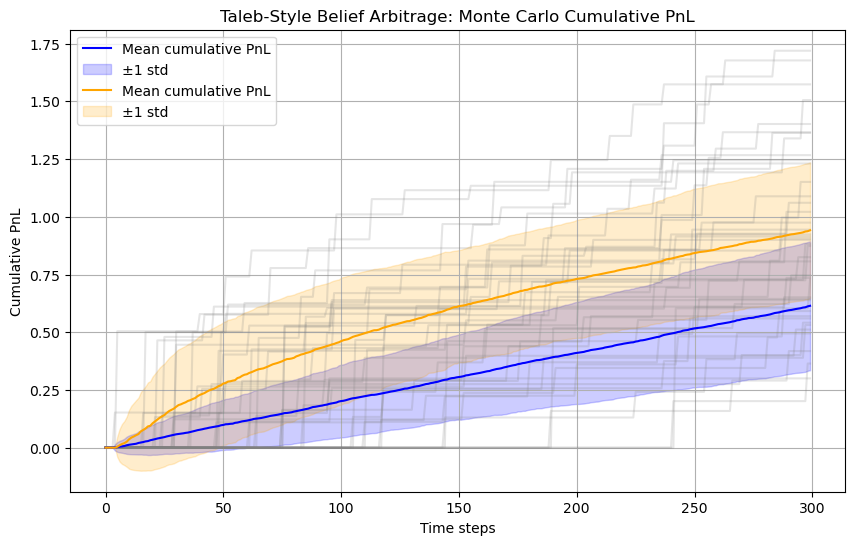

Average final PnL: 0.6145 ± 0.2792


In [83]:
# === Parameters ===
N = 500              # number of simulations
T = 300              # time steps per simulation
dt = 1
mu = -0.5            # mean reversion (arbitrageable drift)
sigma = 0.15         # volatility of belief updates
p0 = 0.5             # starting belief
upper, lower = 0.6, 0.4  # trading thresholds

# === Storage ===
cum_pnls = np.zeros((N, T))
cum_pnls_fees = np.zeros((N, T))
# === Monte Carlo Simulation ===
for n in range(N):
    # generate latent logit process
    x = np.zeros(T)
    x[0] = np.log(p0 / (1 - p0))
    for t in range(1, T):
        dx = mu * x[t-1] * dt + sigma * np.random.randn()
        x[t] = x[t-1] + dx
    p = 1 / (1 + np.exp(-x))  # convert to probability
    
    # --- mean reversion strategy: discrete entries ---
    in_position = False
    direction = 0      # +1 = long, -1 = short
    entry_price = 0.0
    pnl = 0.0
    cum_pnl = [0.0]
    cum_pnl_fee = [0,0]
    for t in range(1, T):
        pt = p[t]
        
        if not in_position:
            # entry logic
            if pt > upper:
                in_position = True
                direction = -1
                entry_price = pt 
            elif pt < lower:
                in_position = True
                direction = 1
                entry_price = pt
            cum_pnl.append(cum_pnl[-1])
            cum_pnl_fee.append(cum_pnl_fee[-1])
        else:
            # exit condition: cross back to mid (0.5)
            if (direction == 1 and pt >= 0.5) or (direction == -1 and pt <= 0.5):
                trade_pnl = direction * (pt - entry_price)
                pnl += trade_pnl
                cum_pnl.append(cum_pnl[-1] + trade_pnl)
                cum_pnl_fee.append(cum_pnl[-1] + trade_pnl + .2)
                in_position = False
                direction = 0
            else:
                cum_pnl.append(cum_pnl[-1])  # hold
                cum_pnl_fee.append(cum_pnl_fee[-1])
    cum_pnls[n, :] = cum_pnl[:T]
    cum_pnls_fees[n, :] = cum_pnl_fee[:T]
    
    
# === Results ===
mean_pnl = cum_pnls.mean(axis=0)
pnl_std = cum_pnls.std(axis=0)

mean_pnl_fees = cum_pnls_fees.mean(axis=0)
pnl_std_fees = cum_pnls_fees.std(axis=0)


# --- Plot sample paths ---
plt.figure(figsize=(10,6))
for i in range(20):
    plt.plot(cum_pnls[i], color='gray', alpha=0.2)
    plt.plot(cum_pnls_fees[i], color='gray', alpha=0.2)
plt.plot(mean_pnl, color='blue', label='Mean cumulative PnL')
plt.fill_between(range(T), mean_pnl - pnl_std, mean_pnl + pnl_std,
                 color='blue', alpha=0.2, label='±1 std')

plt.plot(mean_pnl_fees, color='orange', label='Mean cumulative PnL')
plt.fill_between(range(T), mean_pnl_fees - pnl_std_fees, mean_pnl_fees + pnl_std_fees,
                 color='orange', alpha=0.2, label='±1 std')
plt.title("Taleb-Style Belief Arbitrage: Monte Carlo Cumulative PnL")
plt.xlabel("Time steps")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.grid(True)
plt.show()

print(f"Average final PnL: {mean_pnl[-1]:.4f} ± {pnl_std[-1]:.4f}")

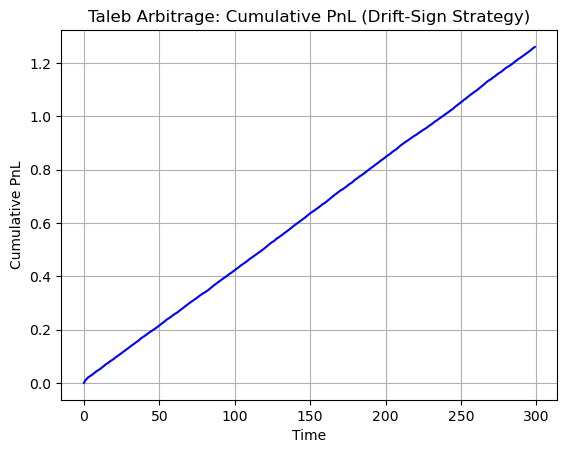

In [57]:
import numpy as np
import matplotlib.pyplot as plt

N, T = 500, 300
mu, sigma = -0.3, 0.05
p0 = 0.5
dt = 1

cum_pnls = np.zeros((N, T))

for n in range(N):
    x = np.zeros(T)
    x[0] = np.log(p0 / (1 - p0))
    for t in range(1, T):
        dx = mu * x[t-1] * dt + sigma * np.random.randn()
        x[t] = x[t-1] + dx
    p = 1 / (1 + np.exp(-x))
    dp = np.diff(p, prepend=p[0])
    exp_drift = mu * x * dt
    position = -np.sign(exp_drift)
    returns = dp * position
    cum_pnls[n] = np.cumsum(returns)

mean_pnl = cum_pnls.mean(axis=0)
plt.plot(mean_pnl, color='blue')
plt.title("Taleb Arbitrage: Cumulative PnL (Drift-Sign Strategy)")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.show()
